# Degridder experiment

Here, we're comparing with the Preesm implementation available at https://gitlab.insa-rennes.fr/Anaelle.Cloarec/degridder

First, let's run and measure all scenarios.

In [20]:
experiment_dir = !realpath ~/repos/iara/experiment/degridder
experiment_dir = experiment_dir[0]

class Scenario:
  def __init__(self, name: str):
    self.name = name
    self.instance_path = f"{experiment_dir}/instances/{name}"
    self.iara_bin_path = None
    self.preesm_bin_path = None
    self.iara_scheduling_time = None
    self.preesm_scheduling_time = None
    self.srdag_edges = None
    self.srdag_nodes = None
    self.preesm_bin_size = None
    self.iara_bin_size = None
    self.num_cores, self.num_kernel_supports, self.num_chunks = map(int,name.removesuffix(".scenario").split("_")[2:5])
    self.dataset_size = name.split("_")[1]

# take only PXX_ scenarios, sort by number

all_scenarios = !ls ~/repos/degridder/Scenarios
all_scenarios = list(filter(lambda x: str(x).startswith("P") and not "complete" in str(x) and not "medium" in str(x), all_scenarios))
all_scenarios.sort(key=lambda x: int(str(x).split('_')[0].strip('P')))
all_scenarios

scenarios : dict[str, Scenario] = {name: Scenario(name) for name in all_scenarios}

[i.__dict__ for i in scenarios.values()]

[{'name': 'P1_small_1_8_1.scenario',
  'instance_path': '/home/jabcross/repos/iara/experiment/degridder/instances/P1_small_1_8_1.scenario',
  'iara_bin_path': None,
  'preesm_bin_path': None,
  'iara_scheduling_time': None,
  'preesm_scheduling_time': None,
  'srdag_edges': None,
  'srdag_nodes': None,
  'preesm_bin_size': None,
  'iara_bin_size': None,
  'num_cores': 1,
  'num_kernel_supports': 8,
  'num_chunks': 1,
  'dataset_size': 'small'},
 {'name': 'P2_small_32_8_64.scenario',
  'instance_path': '/home/jabcross/repos/iara/experiment/degridder/instances/P2_small_32_8_64.scenario',
  'iara_bin_path': None,
  'preesm_bin_path': None,
  'iara_scheduling_time': None,
  'preesm_scheduling_time': None,
  'srdag_edges': None,
  'srdag_nodes': None,
  'preesm_bin_size': None,
  'iara_bin_size': None,
  'num_cores': 32,
  'num_kernel_supports': 8,
  'num_chunks': 64,
  'dataset_size': 'small'},
 {'name': 'P3_small_32_8_128.scenario',
  'instance_path': '/home/jabcross/repos/iara/experiment

In [21]:
# Let's test with just a small one for now.

def small_test():
  global scenarios
  all_scenarios = ["P2_small_32_8_64.scenario"]
  scenarios = {name: Scenario(name) for name in all_scenarios}

small_test()

In [26]:
# Compile Preesm versions, with a timeout.

def compile_preesm():

  %cd {experiment_dir}
  !rm -rf instances
  !mkdir -p instances

  for scenario_obj in scenarios:

    scenario = scenario_obj.name

    !mkdir -p "{experiment_dir}/instances/{scenario}"

    ! \time -v -o "{experiment_dir}/instances/{scenario}/preesm_scheduling_time.txt" timeout 3m ~/repos/preesm-cli/commandLinePreesm.sh ~/Downloads/preesm-3.21.0.202501251928-linux.gtk.x86_64/ ~/repos/degridder/ Codegen.workflow {scenario} >{experiment_dir}/instances/{scenario}/preesm_stdout.txt 2>{experiment_dir}/instances/{scenario}/preesm_stderr.txt

    %cd ~/repos/degridder/Code

    !mkdir -p build
    !rm -rf build/*
    !cmake -DCMAKE_BUILD_TYPE=Release --log-level=VERBOSE -B build
    %cd build
    !make

    ! rm -rf "{experiment_dir}/instances/{scenario}/preesm_build"
    ! cp -r ~/repos/degridder/Code/build "{experiment_dir}/instances/{scenario}/preesm_build"


In [22]:
# get data from preesm compilation sizes

import os
import re

for scenario in scenarios.values():
  scenario.preesm_bin_path = f'{experiment_dir}/instances/{scenario.name}/preesm_build/degridder_pipeline'
  if os.path.exists(scenario.preesm_bin_path):
    scenario.preesm_bin_size = os.path.getsize(scenario.preesm_bin_path)
    walltime_str = ! grep "wall clock" '{experiment_dir}/instances/{scenario.name}/preesm_scheduling_time.txt' | cut -f 8 -d ' '
    time_str = walltime_str[0].strip()
    minutes, seconds = time_str.split(':')
    scenario.preesm_scheduling_time = float(minutes) * 60 + float(seconds)

  srdag_output = ! grep "SRDAG" {experiment_dir}/instances/{scenario.name}/preesm_stdout.txt
  if srdag_output and len(srdag_output) > 0:
    match = re.search(r'SRDAG with (\d+) vertices and (\d+) edges', srdag_output[0])
    if match:
      scenario.srdag_nodes = int(match.group(1))
      scenario.srdag_edges = int(match.group(2))
    else:
      scenario.srdag_nodes = None
      scenario.srdag_edges = None

!ls -lah {experiment_dir}/instances/*/preesm_build/degridder_pipeline

[(s.name, s.preesm_bin_size, s.srdag_nodes, s.srdag_edges) for s in scenarios.values()]

-rwxr-xr-x. 1 jabcross jabcross 1.8M Aug 18 09:49 /home/jabcross/repos/iara/experiment/degridder/instances/P10_large_64_4_256.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 628K Aug 18 09:49 /home/jabcross/repos/iara/experiment/degridder/instances/P11_large_1_8_1.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 930K Aug 18 09:50 /home/jabcross/repos/iara/experiment/degridder/instances/P12_large_32_8_64.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.2M Aug 18 09:51 /home/jabcross/repos/iara/experiment/degridder/instances/P13_large_32_8_128.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.2M Aug 18 09:51 /home/jabcross/repos/iara/experiment/degridder/instances/P14_large_64_8_128.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 630K Aug 18 09:39 /home/jabcross/repos/iara/experiment/degridder/instances/P1_small_1_8_1.scenario/preesm_build/degridder_pipeline
-rwxr-

[('P2_small_32_8_64.scenario', 951056, 82, 465)]

Now, let's compile our version.

In [24]:
all_scenarios

parameters = {}

%cd {experiment_dir}

for name, scenario in scenarios.items():
# for name, scenario in {"P1_small_1_8_1.scenario": scenarios["P1_small_1_8_1.scenario"]}.items():
  scenario.topology_file = f"{experiment_dir}/instances/{name}/build/topology.mlir"
  scenario.main_file = f"{experiment_dir}/instances/{name}/build/main.cpp"
  scenario.iara_build_dir = f"{experiment_dir}/instances/{name}/build"
  ! mkdir -p {scenario.iara_build_dir}
  ! rm -rf {scenario.iara_build_dir}/*
  %cd {scenario.iara_build_dir}
  assert os.getcwd() == scenario.iara_build_dir, f"Not in expected build dir: {os.getcwd()} vs {scenario.iara_build_dir}"
  ! SCHEDULER_MODE=virtual-fifo sh -x ../../../build_instance.sh


/home/jabcross/repos/iara/experiment/degridder
/home/jabcross/repos/iara/experiment/degridder/instances/P2_small_32_8_64.scenario/build
+++ realpath .
++ basename /home/jabcross/repos/iara/experiment/degridder/instances/P2_small_32_8_64.scenario/build
+ [[ build -ne build ]]
+ [[ -z virtual-fifo ]]
+ build-iara.sh
-- Using MLIRConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/mlir
-- Using LLVMConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/llvm
CMake Warning at /home/jabcross/repos/clangir/build/lib/cmake/llvm/HandleLLVMOptions.cmake:88 (message):
  Job pooling is only available with Ninja generators.
Call Stack (most recent call first):
  CMakeLists.txt:33 (include)


-- Building with -fPIC
-- Configuring done (0.2s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jabcross/repos/iara/build
[  6%] Built target MLIRIaraPassesIncGen
[  6%] Built target mlir-generic-headers
[ 21%] Built target MLIRIaraOpsIncGen
[ 21%] Built target mlir-heade

In [3]:
# get iara binary data

for scenario in scenarios.values():
  scenario.iara_bin_path = f'{experiment_dir}/instances/{scenario.name}/build/degridder_pipeline'
  if os.path.exists(scenario.iara_bin_path):
    scenario.iara_bin_size = os.path.getsize(scenario.iara_bin_path)
    walltime_str = ! grep "wall clock" '{experiment_dir}/instances/{scenario.name}/iara_scheduling_time.txt' | cut -f 8 -d ' '
    time_str = walltime_str[0].strip()
    minutes, seconds = time_str.split(':')
    scenario.iara_scheduling_time = float(minutes) * 60 + float(seconds)


!ls -lah {experiment_dir}/instances/*/build/degridder_pipeline

[(s.name, s.iara_bin_size) for s in scenarios.values()]

-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:39 /home/jabcross/repos/iara/experiment/degridder/instances/P10_large_64_4_256.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:39 /home/jabcross/repos/iara/experiment/degridder/instances/P11_large_1_8_1.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:39 /home/jabcross/repos/iara/experiment/degridder/instances/P12_large_32_8_64.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:40 /home/jabcross/repos/iara/experiment/degridder/instances/P13_large_32_8_128.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:40 /home/jabcross/repos/iara/experiment/degridder/instances/P14_large_64_8_128.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 07:40 /home/jabcross/repos/iara/experiment/degridder/instances/P15_large_64_8_256.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 844K Aug 19 

[('P1_small_1_8_1.scenario', 863336),
 ('P2_small_32_8_64.scenario', 863336),
 ('P3_small_32_8_128.scenario', 863336),
 ('P4_small_64_8_128.scenario', 863336),
 ('P5_small_64_8_256.scenario', 863336),
 ('P6_large_1_4_1.scenario', 863336),
 ('P7_large_32_4_64.scenario', 863336),
 ('P8_large_32_4_128.scenario', 863336),
 ('P9_large_64_4_128.scenario', 863336),
 ('P10_large_64_4_256.scenario', 863336),
 ('P11_large_1_8_1.scenario', 863336),
 ('P12_large_32_8_64.scenario', 863336),
 ('P13_large_32_8_128.scenario', 863336),
 ('P14_large_64_8_128.scenario', 863336),
 ('P15_large_64_8_256.scenario', 863336),
 ('P16_large_64_8_1024.scenario', 863352),
 ('P17_large_64_4_512.scenario', 863336),
 ('P18_small_64_8_512.scenario', 863336)]

In [16]:
# Helper functions for plotting to reduce code repetition

from typing import List, Optional, Union
import matplotlib.axes
import numpy as np


def add_timeout_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]], bar_width_offset: float = 0) -> float:
    """Add 'Timeout' labels for None values in the data and return their height in graph units"""
    timeout_height_in_graph_units = 0

    for idx, val in enumerate(values):
        if val is None:
            # Add the timeout label
            text_obj = ax.text(x_positions[idx] + bar_width_offset, 0.5, 'Timeout',
                               ha='center', va='bottom', color='red', rotation=90)

            # Calculate the height of the rotated text in graph units
            # For a 90-degree rotated text, the height becomes the width in graph coordinates
            renderer = ax.figure.canvas.get_renderer()
            bbox = text_obj.get_window_extent(renderer=renderer)

            # Transform from display coordinates to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())

            # For rotated text (90 degrees), width in display becomes height in graph
            text_width_in_data = bbox_data.height
            # This is the "height" of rotated text
            text_height_in_graph = text_width_in_data

            timeout_height_in_graph_units = max(
                timeout_height_in_graph_units, text_height_in_graph + 0.5)

    return timeout_height_in_graph_units


def add_edge_count_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                          srdag_edges: List[Optional[int]], offset_percentage: float = 0.05,
                          timeout_height: float = 0) -> None:
    """Add edge count labels above bars, with offset relative to graph scale"""
    # Calculate offset based on the current y-axis range
    y_min, y_max = ax.get_ylim()
    graph_scale_offset = (y_max - y_min) * offset_percentage

    for idx, edge_count in enumerate(srdag_edges):
        if edge_count is not None:
            max_height = values[idx] if values[idx] is not None else 0
            max_height = max(max_height, (timeout_height *1.1) if values[idx] is None else 0)

            y_position = max_height + graph_scale_offset

            ax.text(x_positions[idx], y_position,
                    f"#edges:\n{edge_count}",
                    ha='center', va='bottom', fontsize=8, color='black')


def setup_bar_plot(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                   bar_width: float, color_map: List[str],
                   ylabel: str, xlabel: str, title: str, scenario_names: List[str]) -> matplotlib.container.BarContainer:
    """Setup a basic bar plot with common formatting"""
    bars = ax.bar(x_positions, [v if v is not None else 0 for v in values],
                  bar_width, color=color_map)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(scenario_names, rotation=90)
    return bars


def set_ylim_with_padding(ax: matplotlib.axes.Axes, values: List[Optional[float]],
                          padding_factor: float = 1.2, min_timeout_space: float = 20.0) -> None:
    """Set y-axis limits with padding to accommodate labels and timeout scenarios"""
    max_val = max([v for v in values if v is not None], default=0)
    if max_val > 0:
        ax.set_ylim(0, max_val * padding_factor)
    else:
        # If all values are None (timeouts), ensure enough space for labels
        ax.set_ylim(0, min_timeout_space)

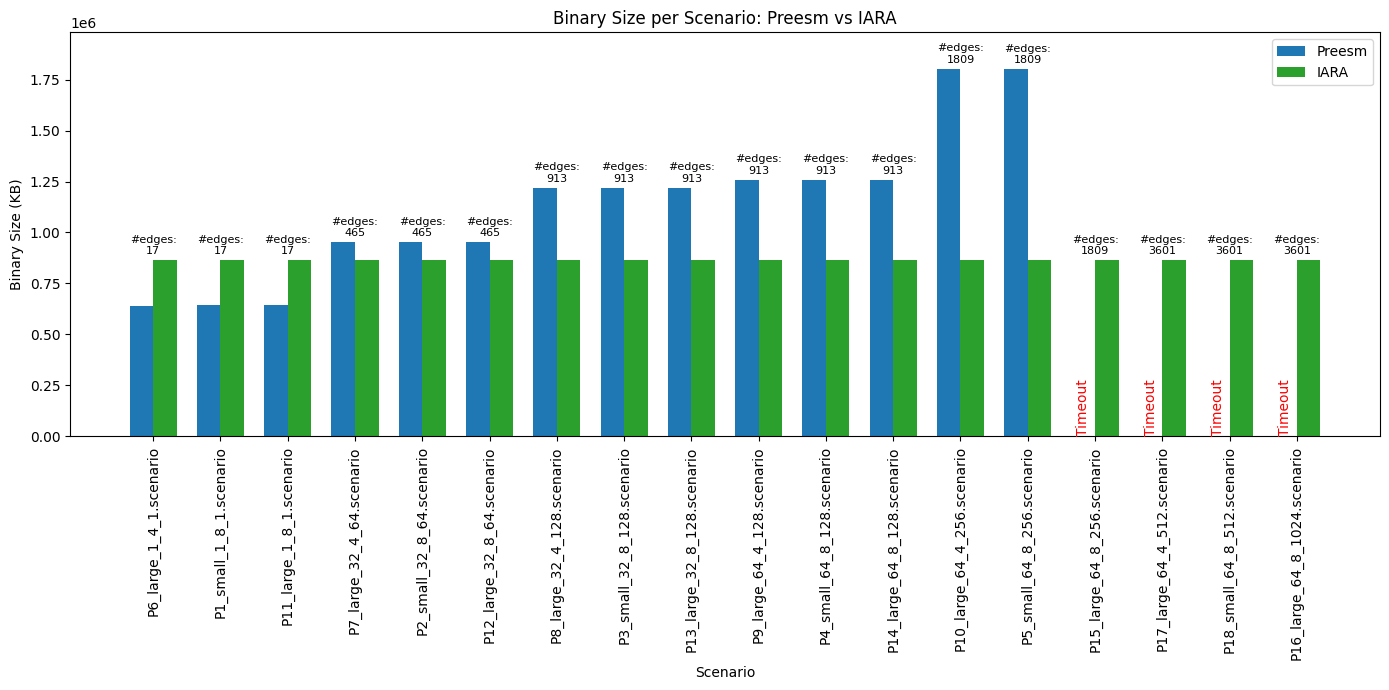

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Map scenario name to Preesm binary path
preesm_binary_map = {}
iara_binary_map = {}

# Collect sizes for both Preesm and IARA
preesm_sizes = []
iara_sizes = []

scenario_list : list[Scenario] = list(scenarios.values())

scenario_list.sort(key = lambda s: (s.srdag_edges if s.srdag_edges else 9999999999, s.num_cores, s.num_chunks, s.num_kernel_supports))

scenario_names = [s.name for s in scenario_list]
preesm_sizes = [s.preesm_bin_size for s in scenario_list]
iara_sizes = [s.iara_bin_size for s in scenario_list]
srdag_edges = [s.srdag_edges for s in scenario_list]

x = np.arange(len(scenario_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))

# Create color maps for the bars
preesm_colors = ['tab:blue' if s is not None else 'tab:red' for s in preesm_sizes]
iara_colors = ['tab:green' if s is not None else 'tab:red' for s in iara_sizes]

# Plot bars
bars1 = ax.bar(x - width/2, [s if s is not None else 0 for s in preesm_sizes], 
              width, label='Preesm', color=preesm_colors)
bars2 = ax.bar(x + width/2, [s if s is not None else 0 for s in iara_sizes], 
              width, label='IARA', color=iara_colors)

ax.set_ylabel('Binary Size (KB)')
ax.set_xlabel('Scenario')
ax.set_title('Binary Size per Scenario: Preesm vs IARA')
ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=90)
ax.legend()

# Add timeout labels
add_timeout_labels(ax, x, preesm_sizes, -width/2)
add_timeout_labels(ax, x, iara_sizes, width/2)

# Add edge count labels
for idx, edge_count in enumerate(srdag_edges):
  if edge_count is not None:
    max_height = max(
      (preesm_sizes[idx] if preesm_sizes[idx] is not None else 0),
      (iara_sizes[idx] if iara_sizes[idx] is not None else 0)
    )
    ax.text(x[idx], max_height + 20000, f"#edges:\n{edge_count}", 
           ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits
ymax = max(
  [s for s in preesm_sizes if s is not None] + 
  [s for s in iara_sizes if s is not None]
)
ax.set_ylim(0, ymax * 1.1)

plt.tight_layout()
plt.show()

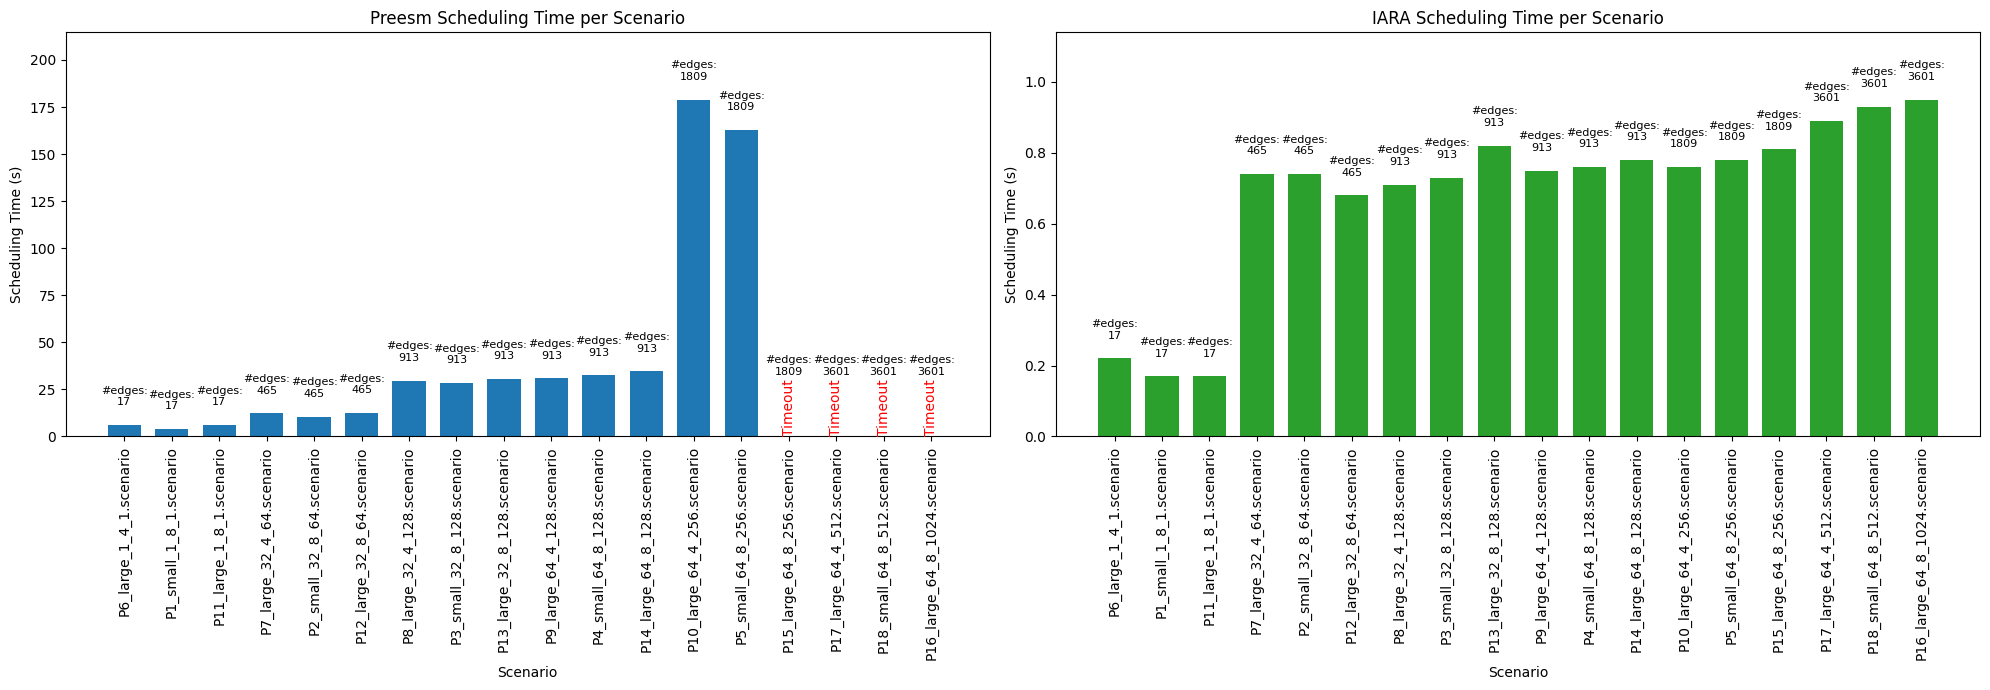

In [17]:
# Prepare scheduling times for Preesm and IARA
preesm_times = [s.preesm_scheduling_time for s in scenario_list]
iara_times = [s.iara_scheduling_time for s in scenario_list]

# Create two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps
preesm_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_times]
iara_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_times]

# Plot Preesm times
setup_bar_plot(ax1, x, preesm_times, width*2, preesm_colors,
               'Scheduling Time (s)', 'Scenario', 'Preesm Scheduling Time per Scenario', 
               scenario_names)

timeout_height = add_timeout_labels(ax1, x, preesm_times)
add_edge_count_labels(ax1, x, preesm_times, srdag_edges, timeout_height=timeout_height)
set_ylim_with_padding(ax1, preesm_times, 1.2)

# Plot IARA times
setup_bar_plot(ax2, x, iara_times, width*2, iara_colors,
               'Scheduling Time (s)', 'Scenario', 'IARA Scheduling Time per Scenario', 
               scenario_names)

add_timeout_labels(ax2, x, iara_times)
add_edge_count_labels(ax2, x, iara_times, srdag_edges, timeout_height=0)
set_ylim_with_padding(ax2, iara_times, 1.2)

plt.tight_layout()
plt.show()

In [ ]:

from timeit import default_timer as timer

source_dir = "~/repos/degridder/Code"

for scenario in scenarios:
  name = scenario["name"]
  topology_file = scenario["topology_file"]
  build_dir = scenario["build_dir"]

  main_actor_name = "top_parallel_degridder_complete" if "complete" in name else "top_parallel_degridder"

  start = timer()

  ! pwd

  %cd {build_dir}

  ! iara-opt --iara-canonicalize --flatten --virtual-fifo='main-actor={main_actor_name} ' "topology.mlir" > "schedule.mlir"

  end = timer()

  scenario["iara_opt_time"] = end - start

  print("Generating schedule took ", end - start)


# CPP_COMPILER=$LLVM_INSTALL/bin/clang++
# C_COMPILER=$LLVM_INSTALL/bin/clang
# COMPILER_FLAGS="-stdlib=libc++ -fopenmp"
# LINKER_FLAGS=" "


  ! sh -x mlir-to-llvmir.sh schedule.mlir

  ! $LLVM_INSTALL/bin/clang -g -fopenmp -xir -c schedule.ll -o schedule.o

  ! $LLVM_INSTALL/bin/clang++ -std=c++26 -g -fopenmp -c -I{source_dir}/include main.cpp -o broadcasts.o

  ! echo {source_dir}


  link_command = ("$LLVM_INSTALL/bin/clang -g -fuse-ld=mold -stdlib=libc++ "
  + "-L$LLVM_INSTALL/lib -lomp -lpthread -lc++ -lc++abi -L/usr/lib64 "
  + "*.o "
  + f" {source_dir}/build/CMakeFiles/degridder_pipeline.dir/src/fft_run.c.o"
  + f" {source_dir}/build/CMakeFiles/degridder_pipeline.dir/src/degridding.c.o"
  + f" {source_dir}/build/CMakeFiles/degridder_pipeline.dir/src/common.c.o"
  + f" {source_dir}/build/CMakeFiles/degridder_pipeline.dir/src/top.c.o"
  + f" {source_dir}/build/CMakeFiles/degridder_pipeline.dir/src/vis_to_csv.c.o"
  # + f"*.o"
  )
  
  ! {link_command}



/home/jabcross/repos/iara/experiment/degridder/instances/P18_small_64_8_512.scenario/build
/home/jabcross/repos/iara/experiment/degridder/instances/P1_small_1_8_1.scenario/build
%0 = iara.node @load_image_from_file
  in
    <<UNKNOWN SSA VALUE>> : tensor<1x!llvm.struct<"struct.Config", (i8, i32, i32, i32, i32, f64, ptr, ptr, i32, i32, i8, i8, i8, i8, i8, i8, i8, ptr, ptr, ptr, ptr, ptr, ptr, i8, i8, i32, i32, i8, f64, i32, f64, i32, i32, i32, f64, f64, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, i32, i32, f64, f64, f64, f64, f64, ptr, ptr, ptr, i32, ptr)>>
  out
    tensor<2560x2560x!llvm.struct<"struct.float2", (f32, f32)>>
%0 = iara.node @visibility_host_set_up2
  in
    <<UNKNOWN SSA VALUE>> : tensor<1x!llvm.struct<"struct.Config", (i8, i32, i32, i32, i32, f64, ptr, ptr, i32, i32, i8, i8, i8, i8, i8, i8, i8, ptr, ptr, ptr, ptr, ptr, ptr, i8, i8, i32, i32, i8, f64, i32, f64, i32, i32, i32, f64, f64, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, ptr, i32, i32, f64, f64,